# Prescriptive Analytics to Improve Store Sales Forecast using Explainable-AI

## Installation and Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

#loading packages
# basic + dates
import numpy as np
import pandas as pd 
from datetime import datetime

# data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns #advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF #probability distribution
from scipy.stats import zscore

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose #Seasonal decomposition using moving averages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Plot auto correlation function

# modelling
from catboost import CatBoostRegressor #Training and applying models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
#combining training data
train_1 = pd.read_csv("train-1.csv",
                      parse_dates= True, low_memory= False, index_col= 'Date')

train_2 = pd.read_csv("train-2.csv",
                      parse_dates= True, low_memory= False, index_col= 'Date')

train = pd.concat([train_1,train_2], axis = 0)

store = pd.read_csv("store.csv",
                    low_memory= False)

In [5]:
train.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
train.shape

(1017209, 8)

In [7]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
store.shape

(1115, 10)

## SUMMARY STATISTICS

In [9]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


* This data contains 1.02 million rows of datapoints related to the stores
* The maximum sales was found to have $41551 on a particular dat while we also found some stores having no sales on some days.
* The Customers is a causal feature as it contributes towards the $0 sales for some stores.

In [10]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [11]:
len(store.Store.unique())

1115

## Missing Values

In [13]:
# Stores that are closed
closed_store = train[(train.Open == 0)]
closed_store.shape

(172817, 8)

* The aforementioned stores are anomolous to our model as we are looking into stores sales which would be affected by these dates when the store was closed.
* Remove missing values

In [17]:
no_sales = train[(train.Open == 1) & (train.Sales == 0)]
no_sales.shape

(54, 8)

In [19]:
no_sales.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1
2015-03-26,674,4,0,0,1,0,0,0
2015-02-05,699,4,0,0,1,1,0,0
2014-10-01,708,3,0,0,1,1,0,0
2014-09-22,357,1,0,0,1,0,0,0


* 1 - 5 = Monday - Friday

## Time-Series Decomposition

In [22]:
overall_sales_group = train.groupby(['Date']).agg('sum')
overall_sales_group.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,621182,2228,97235,19491,17,0,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,1114
2013-01-02,622170,3345,6949829,834075,1111,0,0000000000000000000000000000000000000000000000...,1115
2013-01-03,622170,4460,6347820,761040,1109,0,0000000000000000000000000000000000000000000000...,1040
2013-01-04,622170,5575,6638954,782137,1108,0,0000000000000000000000000000000000000000000000...,1040
2013-01-05,622170,6690,5951593,687472,1107,0,0000000000000000000000000000000000000000000000...,112


In [23]:
overall_sales_group['Sales']

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

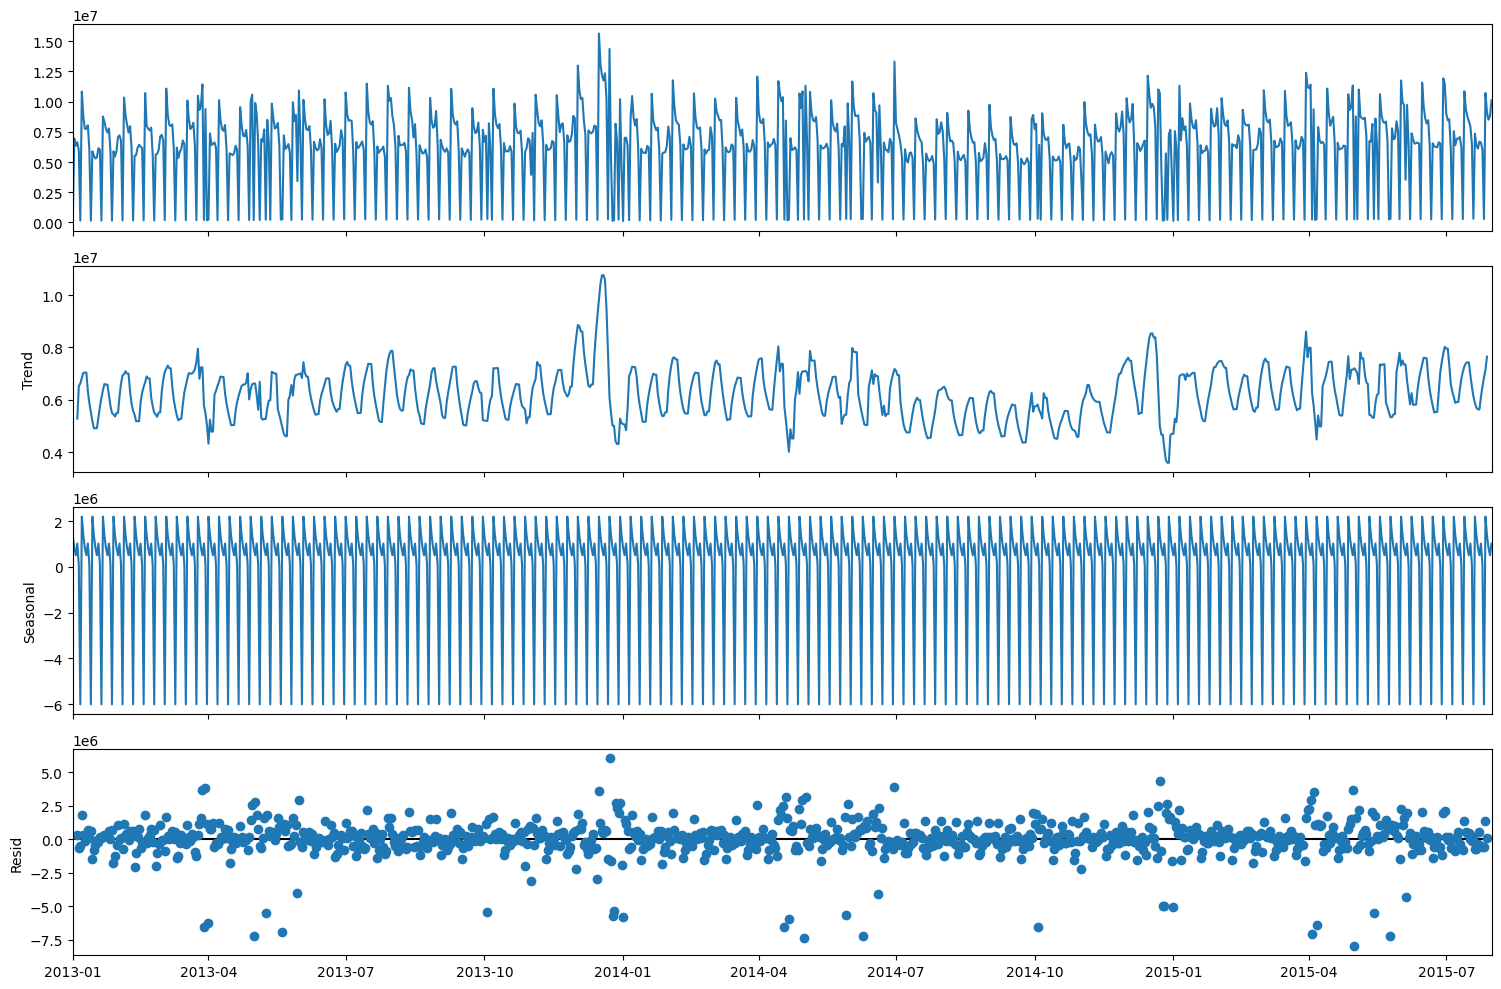

In [31]:
decomposition_1 = seasonal_decompose(overall_sales_group[['Sales']])
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]
fig = decomposition_1.plot()


* We find the a constant weekly seasonailty without much change in the values overall on a week to week basis.
* In the Trend plot, we find during December we find higher sales volume compared to the rest of the year due to holiday season.

In [32]:
train.groupby(['Date', 'Store']).agg('sum')

DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date       Store                                                          
2013-01-01 1              2      0          0     0      0            a   
           2              2      0          0     0      0            a   
           3              2      0          0     0      0            a   
           4              2      0          0     0      0            a   
           5              2      0          0     0      0            a   
...                     ...    ...        ...   ...    ...          ...   
2015-07-31 1111           5   5723        422     1      1            0   
           1112           5   9626        767     1      1            0   
           1113           5   7289        720     1      1            0   
           1114           5  27508       3745     1      1            0   
           1115           5   8680        538     1      1            0   

                  SchoolHoliday  
Date       Store                 
2013-01-01 1                  1  
           2                  1  
           3                  1  
           4                  1  
           5                  1  
...                         ...  
2015-07-31 1111               1  
           1112               1  
           1113               1  
           1114               1  
           1115               1  

[1017209 rows x 7 columns]

In [35]:
store_6_sales_group = train[train['Store'] == 6].groupby(['Date']).agg('sum')
store_6_sales_group.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,6,2,0,0,0,0,a,1
2013-01-02,6,3,6089,781,1,0,0,1
2013-01-03,6,4,5398,689,1,0,0,0
2013-01-04,6,5,6092,724,1,0,0,0
2013-01-05,6,6,3872,467,1,0,0,0


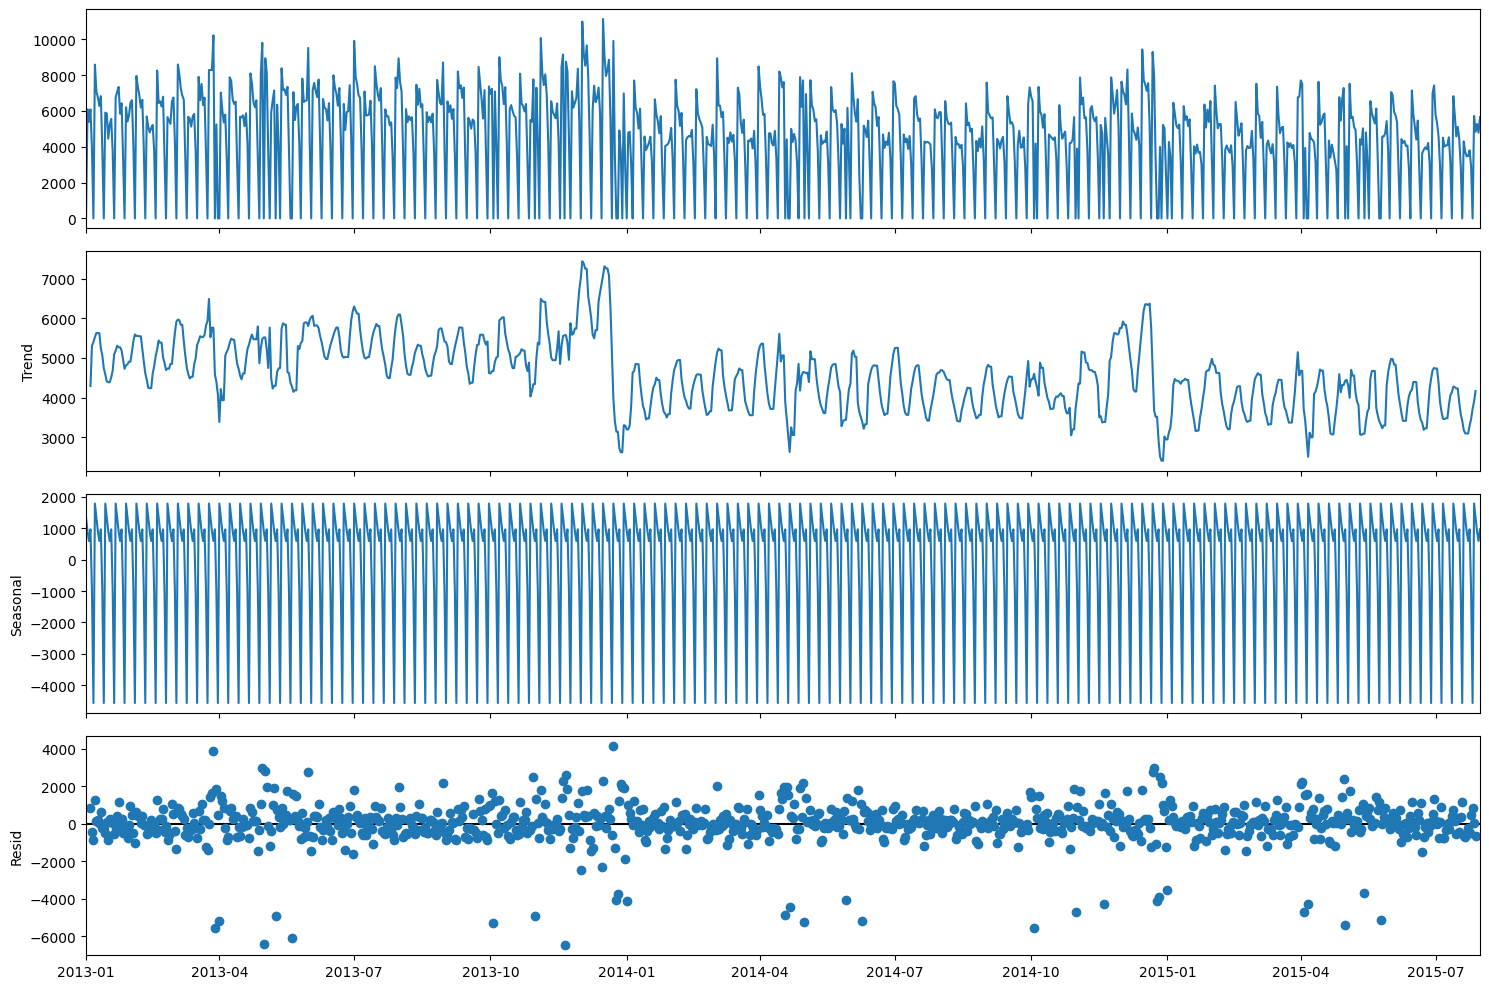

In [37]:
decomposition_2 = seasonal_decompose(store_6_sales_group[['Sales']])
matplotlib.rcParams['figure.figsize'] = [15.0, 10.0]
fig = decomposition_2.plot()

* Looks like sales are dropping starting in 2014
* We found consistent weekly seasonality

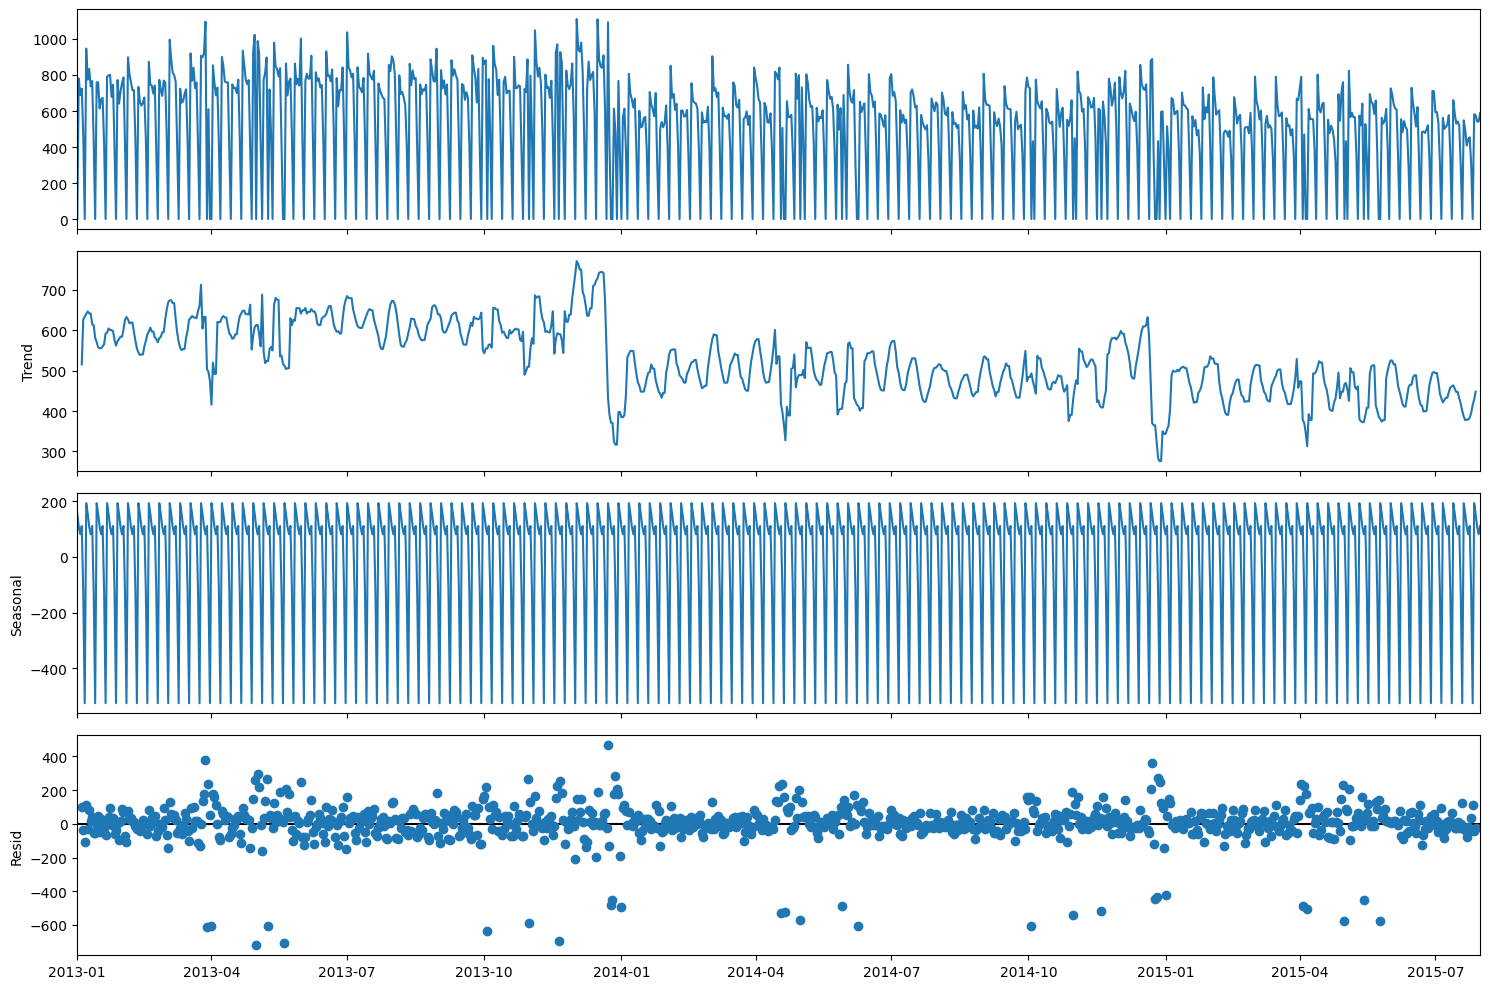

In [38]:
decomposition_3 = seasonal_decompose(store_6_sales_group[['Customers']])
matplotlib.rcParams['figure.figsize'] = [15.0,10.0]
fig = decomposition_3.plot()

## Outliers

<Axes: xlabel='Sales'>

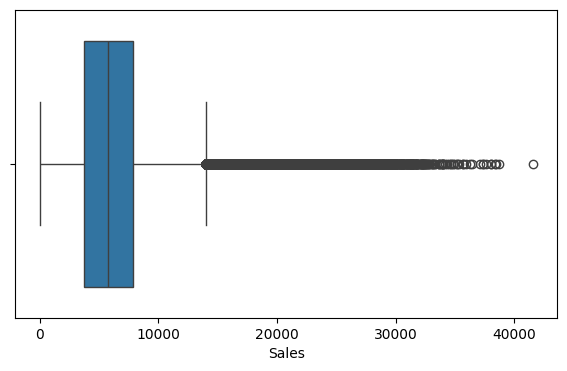

In [41]:
matplotlib.rcParams['figure.figsize'] = [7.0,4.0]
sns.boxplot(x=train["Sales"])

* Sales Outliers: 14,000 and above

<Axes: xlabel='Customers'>

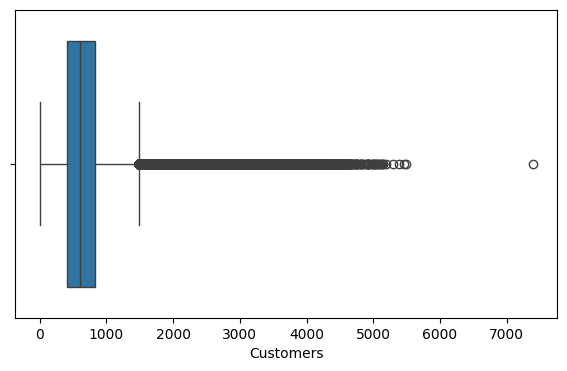

In [42]:
matplotlib.rcParams['figure.figsize'] = [7.0,4.0]
sns.boxplot(x=train["Customers"])

* Customer outlier: 1,500 customers and above

## Data Cleaning

In [44]:
train = train.reset_index()

In [47]:
#Dropping the rows where the stores were closed
train = train[train.Open == 1]

In [66]:
df = train.merge(store, how='left', on='Store')

In [67]:
df.head()

,index,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,2015-07-31,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,2015-07-31,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,2,2015-07-31,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,3,2015-07-31,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,4,2015-07-31,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Feature Correlation Plot

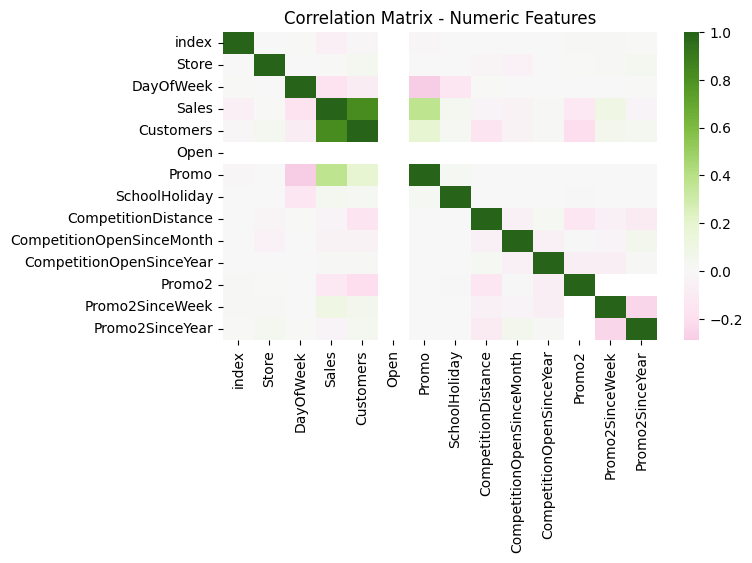

In [68]:
# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Create the correlation matrix heatmap
sns.heatmap(numeric_df.corr(), cmap="PiYG", center=0.0)

# Set the title
plt.title('Correlation Matrix - Numeric Features')

# Show the plot
plt.show()

## Outliers Removal using Z-Score

In [69]:
df['salesZscore'] = zscore(df['Sales'])

In [70]:
#remove all rows with Sales over 3 standard deviations away from the mean
df = df[(df['salesZscore'] <= 3) & (df['salesZscore'] >= -3)]

In [71]:
removable_features = ['Date', 'Store', 'PromoInterval', 'Open', 'salesZscore']

In [72]:
df = df.drop(columns=removable_features)

In [73]:
df.head()

,index,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
0,0,5,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN
1,1,5,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0
2,2,5,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0
3,3,5,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN
4,4,5,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 830955 entries, 0 to 844391
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   index                      830955 non-null  int64  
 1   DayOfWeek                  830955 non-null  int64  
 2   Sales                      830955 non-null  int64  
 3   Customers                  830955 non-null  int64  
 4   Promo                      830955 non-null  int64  
 5   StateHoliday               830955 non-null  object 
 6   SchoolHoliday              830955 non-null  int64  
 7   StoreType                  830955 non-null  object 
 8   Assortment                 830955 non-null  object 
 9   CompetitionDistance        828775 non-null  float64
 10  CompetitionOpenSinceMonth  566837 non-null  float64
 11  CompetitionOpenSinceYear   566837 non-null  float64
 12  Promo2                     830955 non-null  int64  
 13  Promo2SinceWeek            418139 

## Modelling

### CatBoost

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Customers', 'Sales']), df['Sales'], shuffle=False)

In [78]:
model = CatBoostRegressor(cat_features=['StoreType', 'Assortment', 'StateHoliday'], task_type='GPU', devices='0')

In [79]:
model.fit(X_train, y_train)

Learning rate set to 0.093845
0:	learn: 2620.8908142	total: 26.4ms	remaining: 26.4s
1:	learn: 2570.8012335	total: 51ms	remaining: 25.5s
2:	learn: 2529.0278714	total: 76ms	remaining: 25.2s
3:	learn: 2493.6045945	total: 101ms	remaining: 25.1s
4:	learn: 2462.7281388	total: 127ms	remaining: 25.3s
5:	learn: 2437.5914072	total: 153ms	remaining: 25.4s
6:	learn: 2415.2034937	total: 178ms	remaining: 25.3s
7:	learn: 2395.0498567	total: 204ms	remaining: 25.3s
8:	learn: 2377.6198254	total: 230ms	remaining: 25.3s
9:	learn: 2362.3388050	total: 261ms	remaining: 25.8s
10:	learn: 2349.7382903	total: 288ms	remaining: 25.9s
11:	learn: 2337.4670269	total: 313ms	remaining: 25.7s
12:	learn: 2326.3514369	total: 339ms	remaining: 25.7s
13:	learn: 2317.2334166	total: 365ms	remaining: 25.7s
14:	learn: 2308.6397049	total: 391ms	remaining: 25.7s
15:	learn: 2300.9342364	total: 417ms	remaining: 25.7s
16:	learn: 2292.6740926	total: 443ms	remaining: 25.6s
17:	learn: 2286.4821445	total: 469ms	remaining: 25.6s
18:	learn

In [80]:
y_test_pred = model.predict(X_test)

In [81]:
mean_absolute_error(y_test, np.round(y_test_pred))

1020.8876041571394

In [82]:
y_test[:5]

633869    4164
633870    6870
633871    7736
633872    6439
633873    6826
Name: Sales, dtype: int64

In [83]:
y_test_pred[:5]

array([4806.4146818 , 5769.47627957, 7583.25545133, 7172.05682347,
       6517.61399279])

In [84]:
np.mean(y_test)

6542.858139299795

#### Error Rate - CatBoost

In [87]:
error = mean_absolute_error(y_test, np.round(y_test_pred)) / np.mean(y_test)
error

0.15603083276789384

#### Global Feature Importance - CatBoost

In [88]:
importance = pd.DataFrame({'columns': X_train.columns, 'importance': model.feature_importances_})
importance.sort_values('importance', ascending=False).head(20)

,columns,importance
7,CompetitionDistance,27.154263
8,CompetitionOpenSinceMonth,11.888187
9,CompetitionOpenSinceYear,11.765835
2,Promo,10.782753
12,Promo2SinceYear,7.784346
0,index,6.808703
11,Promo2SinceWeek,6.500175
6,Assortment,5.918288
5,StoreType,5.621579
1,DayOfWeek,4.949186


### Decision Tree

In [99]:
df_data_cat = pd.get_dummies(df, prefix=['StoreType', 'Assortment', 'StateHoliday']) #convert categorical (non-numeric) data into a binary format (0s and 1s) that can be fed into machine learning algorithms.
df_data_cat = df_data_cat.fillna(0)
df_data_cat.head()

,index,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,StoreType_a,StoreType_b,StoreType_c,Assortment_a,Assortment_b,Assortment_c,Assortment_d,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0,5,5263,555,1,1,1270.0,9.0,2008.0,0,...,False,False,False,False,False,True,False,True,False,False
1,1,5,6064,625,1,1,570.0,11.0,2007.0,1,...,False,False,False,True,False,False,False,True,False,False
2,2,5,8314,821,1,1,14130.0,12.0,2006.0,1,...,False,False,False,True,False,False,False,True,False,False
3,3,5,13995,1498,1,1,620.0,9.0,2009.0,0,...,False,False,False,False,False,True,False,False,False,True
4,4,5,4822,559,1,1,29910.0,4.0,2015.0,0,...,False,False,False,True,False,False,False,True,False,False


In [90]:
model = DecisionTreeRegressor()

In [100]:
X_train, X_test, y_train, y_test = train_test_split(df_data_cat.drop(columns=['Customers', 'Sales', 'index']),df_data_cat['Sales'], shuffle=False) #It selects the 'Sales' column from the DataFrame df_data_cat and assigns it to y.

In [103]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [102]:
y_test_pred = model.predict(X_test)
mean_absolute_error(y_test, np.round(y_test_pred))

839.8580045152812

#### Error Rate - Decision Tree

In [104]:
error = mean_absolute_error(y_test, np.round(y_test_pred)) / np.mean(y_test)
error

0.12836255756038162

#### Global Feature Importance - Decision Tree

In [105]:
importance = pd.DataFrame({'columns': X_train.columns, 'importance': model.feature_importances_})
importance.sort_values('importance', ascending=False).head(20)

,columns,importance
3,CompetitionDistance,0.327765
1,Promo,0.189103
5,CompetitionOpenSinceYear,0.110075
4,CompetitionOpenSinceMonth,0.088940
0,DayOfWeek,0.080427
7,Promo2SinceWeek,0.052976
8,Promo2SinceYear,0.043605
17,StateHoliday_a,0.021966
16,Assortment_d,0.020559
13,Assortment_a,0.017858


### Random Forest

In [97]:
df_data_cat = pd.get_dummies(df, prefix=['StoreType', 'Assortment', 'StateHoliday'])
df_data_cat = df_data_cat.fillna(0)

In [98]:
df_data_cat.head()

,index,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,StoreType_a,StoreType_b,StoreType_c,Assortment_a,Assortment_b,Assortment_c,Assortment_d,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,0,5,5263,555,1,1,1270.0,9.0,2008.0,0,...,False,False,False,False,False,True,False,True,False,False
1,1,5,6064,625,1,1,570.0,11.0,2007.0,1,...,False,False,False,True,False,False,False,True,False,False
2,2,5,8314,821,1,1,14130.0,12.0,2006.0,1,...,False,False,False,True,False,False,False,True,False,False
3,3,5,13995,1498,1,1,620.0,9.0,2009.0,0,...,False,False,False,False,False,True,False,False,False,True
4,4,5,4822,559,1,1,29910.0,4.0,2015.0,0,...,False,False,False,True,False,False,False,True,False,False


In [107]:
model = RandomForestRegressor(n_jobs=-1) # When n_jobs is set to -1, it means that the algorithm should use all available CPU cores to speed up the training process
X_train, X_test, y_train, y_test = train_test_split(df_data_cat.drop(columns=['Customers', 'Sales', 'index']),df_data_cat['Sales'], shuffle=False)

In [108]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [109]:
y_test_pred = model.predict(X_test)

In [110]:
mean_absolute_error(y_test, np.round(y_test_pred))

839.9741165597216

In [111]:
error = mean_absolute_error(y_test, np.round(y_test_pred)) / np.mean(y_test)
error

0.12838030394001698

#### Global Feature Importance - Random Forest

In [112]:
importance = pd.DataFrame({'columns': X_train.columns, 'importance': model.feature_importances_})
importance.sort_values('importance', ascending=False).head(20)

,columns,importance
3,CompetitionDistance,0.330051
1,Promo,0.187548
5,CompetitionOpenSinceYear,0.107673
4,CompetitionOpenSinceMonth,0.089545
0,DayOfWeek,0.083612
7,Promo2SinceWeek,0.049840
8,Promo2SinceYear,0.046719
17,StateHoliday_a,0.021049
13,Assortment_a,0.018692
14,Assortment_b,0.017142


### Conclusion

* CatBoost: 
    * Inbuilt GPU execution capabilities, and no encode categorical features needed
    * MAE scores 1034 and Avg. Forecast Deviation of 15.80%


* Decision Tree:
    * Created dummy indicator columns for categorical features, and trained the model followed by generating predictions
    * MAE scores 839.79 and Avg. Forecast Deviation of 12.84% 🡺 Best Result


* Random Forest:
    * Created dummy indicator columns for categorical features, and trained the model followed by generating predictions
    * MAE scores 839.94 and Avg. Forecast Deviation of 12.84%

* Global Explainability:
    * We observed that all of the above models considered CompetitionDistance and Promo to be significant features which affect the sales prediction provided by the model.